In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

In [3]:
SAVE_PATH = 'trained/official_res18_25.pth'
SAVE_PATH2 = 'trained/official_res18_25_best.pth'
RUNS_PATH = 'runs/res18'

log_to_tb = True

## Data analysis:

### Train set

| Label name | | Number of images |
| - | | - | 
| hyundai | | 302 | 
| lexus | | 301 | 
| mazda | | 317 | 
| mercedes | | 342 | 
| opel | | 301 | 
| skoda | | 314 | 
| toyota | | 306 | 
| volkswagen | | 330 | 

### Test set
| Label name | | Number of images |
| - | | - | 
| hyundai | | 50 | 
| lexus | | 50 | 
| mazda | | 50 | 
| mercedes | | 50 | 
| opel | | 50 | 
| skoda | | 50 | 
| toyota | | 50 | 
| volkswagen | | 50 | 

In [4]:
%matplotlib inline

### Imports

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image

from copy import deepcopy

### Useful functions to retrive the data

In [6]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [7]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

#### old version

In [8]:
# # wrong_images_path = []
# import traceback

# class CustomImageDataset(Dataset):
#     def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
#         self.img_labels = getLabelList(path_labels)
#         self.images = getImgPool(path_labels)
#         self.transform = transform
#         self.target_transform = target_transform
#         self.use_aug = use_aug

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         try: 
#             image = read_image(self.images.loc[idx][0])
#         except Exception:
#             print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
#         #     wrong_images_path.append(self.images.loc[img_name][0])
#             #return torch.zeros((1, 600, 600)), -1
#         # image = read_image(self.images.loc[img_name][0])
#         if image.shape[0] >= 3: #apply grayscale to colored img
#             image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
#         else: #we have a greyscaled image, move it into tensor 
#             image = to_tensor(ToPILImage()(image))
            
#         image = Resize((300, 300))(image)
#         #data augmentation
#         if self.use_aug:
#             fr = random.choices([0,1],[0.2,0.8])[0]
#             if fr == 1: 
#                 angle = torch.randint(40, size=(1,)).item() - 20
#                 #print (f'Rotate: {angle}')
#                 image = rotate(image, angle)

#             fr = random.choices([0,1],[0.5,0.5])[0]
#             if fr == 1: 
#                 image = hflip(image)
        
#         #image = image.permute(1,2,0) #made to be shown on matplotlib
#         label = self.img_labels.loc[idx][1]
#         #if self.transform:
#         #    image = self.transform(image)
#         #if self.target_transform:
#         #    label = self.target_transform(label)
        
#         return image, label

#### new version (resnet)

In [9]:
# wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.use_aug = use_aug

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try: 
            image = read_image(self.images.loc[idx][0])
        except Exception:
            print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
        #     wrong_images_path.append(self.images.loc[img_name][0])
            #return torch.zeros((1, 600, 600)), -1
        # image = read_image(self.images.loc[img_name][0])
        if image.shape[0] != 3: #color grayscaled and convert RGBA
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=3))
        else: #we have a greyscaled image, move it into tensor 
            image = to_tensor(ToPILImage()(image))
            
        image = Resize((256, 256))(image)
        image = CenterCrop(224)(image)
        image = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
        #data augmentation
        if self.use_aug:
            fr = random.choices([0,1],[0.2,0.8])[0]
            if fr == 1: 
                angle = torch.randint(40, size=(1,)).item() - 20
                #print (f'Rotate: {angle}')
                image = rotate(image, angle)

            fr = random.choices([0,1],[0.5,0.5])[0]
            if fr == 1: 
                image = hflip(image)
        
        #image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.loc[idx][1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        
        return image, label

### Creating the 2 dataset and testing

In [10]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=True)

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2513
test dataset: 400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


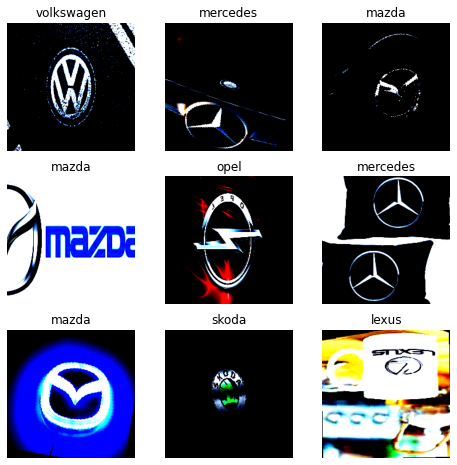

In [11]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    # plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()

### creating dataloader (who iterate on data, create batches and shuffles it)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])


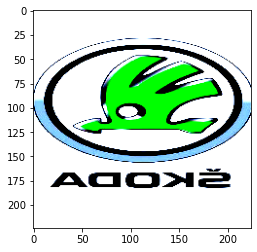

Label: skoda


In [13]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0]#picking the first img and label of the batch
label = labels[0]
# plt.imshow(img, cmap='gray')
plt.imshow(img.permute(1,2,0)) #use this if rbg
plt.show()
print(f"Label: {diz[label.item()]}")

In [14]:
labels

tensor([5, 5, 6, 0, 6, 0, 5, 3])

### Defining the neural network

In [15]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [17]:
# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
        
#         #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)        
#         self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
#         self.fc_layer2 = nn.Linear(120, 84)
#         self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = self.pool(F.relu(self.conv1(x)))
#         #print ('conv1', x.shape)
#         # If the size is a square, you can specify with a single number
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         #print ('flatten', x.shape)
#         x = F.relu(self.fc_layer1(x))
#         x = F.relu(self.fc_layer2(x))
#         x = self.fc_layer3(x)
#         return x

In [18]:
# net = Net()
# net.to(device)

In [19]:
net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
net.to(device)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

62
torch.Size([64, 3, 7, 7])


In [21]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
# best_net = Net()
# best_net.to(device)

In [23]:
best_net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
best_net.to(device)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Tensorboard setup

start tensorboard: `tensorboard --logdir=Users\eliad\Tesi\ProgettoTesi\runs\car_brands_1`

In [24]:
if log_to_tb:
    writer = SummaryWriter(RUNS_PATH)

    # get some random training images
    dataiter = iter(train_dl)
    images, labels = dataiter.next()

    #visualizing and adding images into tb
    for idx in range(4):    
        img = images[idx]
        # plt.imshow(img.squeeze(), cmap='gray')
        # plt.imshow(img.permute(1,2,0)) #use this if rbg
        # plt.show()
        print (img.shape, img.dtype)
        writer.add_image(f"car_brands_images_{idx+1}", img)

    writer.close()

    ### Adding the graph of the network into Tensorboard

    writer.add_graph(net, images.to(device))
    writer.close()

    ### Adding the projector 

#     tmp_dl = DataLoader(train_data, batch_size=100, shuffle=True)
#     images, labels = next(iter(tmp_dl))

#     # get the class labels for each image
#     class_labels = [diz[lab.item()] for lab in labels]
    
    
#     print(len(class_labels))
#     print(len(labels))
#     print(images.size())


#     images = Resize((28, 28))(images)

#     features = images.view(-1, 28 * 28)
#     #this should be something [100, ...] to equal the dim of the labels, with rgb got 300
#     writer.add_embedding(features,
#                         metadata=class_labels,
#                         label_img=images)
    writer.close()

torch.Size([3, 224, 224]) torch.float32
torch.Size([3, 224, 224]) torch.float32
torch.Size([3, 224, 224]) torch.float32
torch.Size([3, 224, 224]) torch.float32


### Confusion matrix during training

In [25]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = netw(inputs.to(device))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #normalization
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    df_cm = pd.DataFrame(cmn, index=[i for i in classes],
                         columns=[i for i in classes])
    fig = plt.figure(figsize=(8, 8), dpi=125)
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    plt.close(fig)
    return im

### Training the network

In [26]:
print(next(net.parameters()).device)

cuda:0


In [27]:
best_test_loss = 10000
for epoch in range(25):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dl):
        # get the inputs; data is a list of [inputsdeviceels]
        inputs, labels = data
        batch_len = len(labels)
        # inputs, labels = data[0].to(device), data[1].to(device)
        #print (inputs.shape)
        #inputs = inputs.permute(0, 3, 1, 2) # to get a shape of [64, 1, 600, 600]
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print (inputs.device, label.device)

        # inputs = inputs.view(64, -1) #1° param specifico io, altri calcola lui (-1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (oudpi=ts.device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        skip = 50
        if i > 0  and i % 50 == 0:    # print every 360 images (8 images per batch, 45 loops)
            print(f'[{epoch + 1}, {i}/{len(train_dl)}] loss: {(running_loss/skip):.3f}')
            # ...log the running loss
            if log_to_tb:
                writer.add_scalar('training loss',
                               running_loss / skip,
                               (epoch * len(train_data)) + (i * batch_len))
            running_loss = 0.0

    #end of an epoch, calculate loss on test set (since it's small and there's no need to split)
    with torch.no_grad():
        test_loss = 0
        test_batch = 0
        net.eval()
        for _, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.permute(0, 3, 1, 2)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_batch += 1
        actual_test_loss = test_loss/test_batch
        print(f"[{epoch + 1}] test loss: {(actual_test_loss):.3f}")
        
        if log_to_tb:
            writer.add_scalar('test loss',
                           test_loss/test_batch,
                           epoch+1)
            # confusion matrix (added from extra step)        
            writer.add_image(f"confusion_matrix at epoch {epoch+1}", createConfusionMatrix(test_dl, net), global_step=epoch)
            writer.close()
            
        if actual_test_loss < best_test_loss:
            best_test_loss = actual_test_loss
            best_net.train()
            best_params = deepcopy(net.state_dict())
            best_net.load_state_dict(best_params)
            best_net.eval()
        else: #discard net and keep the best
            print('swapping nets')
            net.train()
            old_params = deepcopy(best_net.state_dict())
            net.load_state_dict(best_params)
            net.eval()
        

print('Finished Training')
print(f"best test loss: {best_test_loss:.3f}")

[1, 50/315] loss: 3.638
[1, 100/315] loss: 2.189
[1, 150/315] loss: 2.106
[1, 200/315] loss: 2.171
[1, 250/315] loss: 2.149
[1, 300/315] loss: 2.048
[1] test loss: 2.215
[2, 50/315] loss: 2.144
[2, 100/315] loss: 2.068
[2, 150/315] loss: 2.107
[2, 200/315] loss: 2.080
[2, 250/315] loss: 2.008
[2, 300/315] loss: 2.016
[2] test loss: 2.122
[3, 50/315] loss: 2.035
[3, 100/315] loss: 1.776
[3, 150/315] loss: 2.018
[3, 200/315] loss: 1.927
[3, 250/315] loss: 1.868
[3, 300/315] loss: 1.865
[3] test loss: 2.250
swapping nets
[4, 50/315] loss: 2.046
[4, 100/315] loss: 1.910
[4, 150/315] loss: 1.930
[4, 200/315] loss: 1.854
[4, 250/315] loss: 1.869
[4, 300/315] loss: 1.829
[4] test loss: 2.202
swapping nets
[5, 50/315] loss: 2.004
[5, 100/315] loss: 1.966
[5, 150/315] loss: 1.986
[5, 200/315] loss: 1.974
[5, 250/315] loss: 1.880
[5, 300/315] loss: 1.901
[5] test loss: 2.312
swapping nets
[6, 50/315] loss: 2.012
[6, 100/315] loss: 1.999
[6, 150/315] loss: 1.919
[6, 200/315] loss: 1.925
[6, 250/3

In [28]:
#saving the trained model
torch.save(net.state_dict(), SAVE_PATH)
torch.save(best_net.state_dict(), SAVE_PATH2)